In [7]:
import warnings
from cryptography.hazmat.decrepit.ciphers.algorithms import TripleDES, Blowfish
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings("ignore", category=CryptographyDeprecationWarning)

import os
import pandas as pd
import numpy as np
import soundfile as sf  # Use soundfile directly
import librosa
from scipy.signal import get_window
from skimage.transform import resize

# Define paths
base_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database"
audio_dir = os.path.join(base_dir, "audio_and_txt_files")
spectrograms_dir = os.path.join(base_dir, "spectrograms")

# Create spectrograms directory if it doesn't exist
os.makedirs(spectrograms_dir, exist_ok=True)

# Parameters
TARGET_SR = 4000
FIXED_DURATION = 2.7
SAMPLES_PER_CYCLE = int(TARGET_SR * FIXED_DURATION)

# Preprocessing
def parse_filename(filename):
    parts = filename.split('_')
    return {
        "patient_id": int(parts[0]),
        "recording_idx": parts[1],
        "chest_location": parts[2],
        "acquisition_mode": parts[3],
        "equipment": parts[4].replace('.wav', '')
    }

def preprocess_audio(audio_path, annotation_path):
    # Use soundfile instead of librosa.load to avoid audioread
    y, sr = sf.read(audio_path)
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
    annotations = pd.read_csv(annotation_path, delimiter='\t', 
                              names=['start', 'end', 'crackles', 'wheezes'])
    
    cycles, labels, patient_ids = [], [], []
    file_info = parse_filename(os.path.basename(audio_path))
    
    for _, row in annotations.iterrows():
        start_sample = int(row['start'] * TARGET_SR)
        end_sample = int(row['end'] * TARGET_SR)
        cycle = y_resampled[start_sample:end_sample]
        if len(cycle) > SAMPLES_PER_CYCLE:
            cycle = cycle[:SAMPLES_PER_CYCLE]
        elif len(cycle) < SAMPLES_PER_CYCLE:
            cycle = np.pad(cycle, (0, SAMPLES_PER_CYCLE - len(cycle)), 'constant')
        cycles.append(cycle)
        if row['crackles'] == 1 and row['wheezes'] == 1:
            labels.append(3)
        elif row['crackles'] == 1:
            labels.append(1)
        elif row['wheezes'] == 1:
            labels.append(2)
        else:
            labels.append(0)
        patient_ids.append(file_info['patient_id'])
    return np.array(cycles), np.array(labels), np.array(patient_ids)

audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
cycles, labels, patient_ids = [], [], []
for audio_file in audio_files:
    audio_path = os.path.join(audio_dir, audio_file)
    annotation_path = audio_path.replace('.wav', '.txt')
    c, l, p = preprocess_audio(audio_path, annotation_path)
    cycles.append(c)
    labels.append(l)
    patient_ids.append(p)

cycles = np.concatenate(cycles, axis=0)
labels = np.concatenate(labels, axis=0)
patient_ids = np.concatenate(patient_ids, axis=0)

# Compute spectrograms
def compute_spectrogram(cycle):
    window = get_window('hann', 256)
    stft = librosa.stft(cycle, n_fft=256, hop_length=128, window=window)
    spectrogram = np.abs(stft) ** 2
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

spectrograms = np.array([compute_spectrogram(cycle) for cycle in cycles])
spectrograms_resized = np.array([resize(spec, (75, 50), mode='constant') for spec in spectrograms])
spectrograms_resized = np.expand_dims(spectrograms_resized, axis=-1)

print("Spectrograms shape:", spectrograms_resized.shape)

# Save to the spectrograms folder
np.save(os.path.join(spectrograms_dir, "spectrograms_resized.npy"), spectrograms_resized)
np.save(os.path.join(spectrograms_dir, "labels.npy"), labels)
np.save(os.path.join(spectrograms_dir, "patient_ids.npy"), patient_ids)

print(f"Spectrograms, labels, and patient IDs saved to {spectrograms_dir}")

Spectrograms shape: (6898, 75, 50, 1)
Spectrograms, labels, and patient IDs saved to D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database\spectrograms


In [8]:
import numpy as np

spectrograms_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database\spectrograms"
spectrograms_resized = np.load(os.path.join(spectrograms_dir, "spectrograms_resized.npy"))
labels = np.load(os.path.join(spectrograms_dir, "labels.npy"))
patient_ids = np.load(os.path.join(spectrograms_dir, "patient_ids.npy"))

print("Loaded spectrograms shape:", spectrograms_resized.shape)

Loaded spectrograms shape: (6898, 75, 50, 1)


In [3]:
import numpy as np
import os

# Define paths
base_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database"
spectrograms_dir = os.path.join(base_dir, "spectrograms")

# Load spectrograms, labels, and patient IDs
spectrograms_resized = np.load(os.path.join(spectrograms_dir, "spectrograms_resized.npy"))
labels = np.load(os.path.join(spectrograms_dir, "labels.npy"))
patient_ids = np.load(os.path.join(spectrograms_dir, "patient_ids.npy"))

print("Spectrograms shape:", spectrograms_resized.shape)  # Should be (6898, 75, 50, 1)
print("Labels shape:", labels.shape)
print("Patient IDs shape:", patient_ids.shape)

Spectrograms shape: (6898, 75, 50, 1)
Labels shape: (6898,)
Patient IDs shape: (6898,)


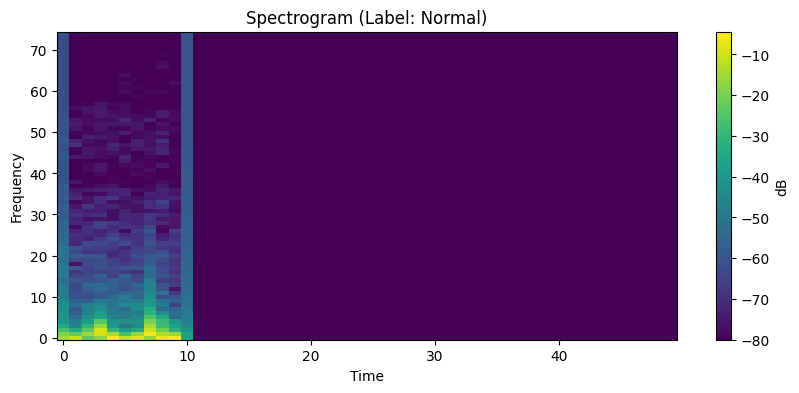

In [6]:
import matplotlib.pyplot as plt

# Visualize the first spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrograms_resized[0, :, :, 0], cmap='viridis', aspect='auto', origin='lower')
plt.title(f"Spectrogram (Label: {['Normal', 'Crackles', 'Wheezes', 'Both'][labels[0]]})")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='dB')
plt.show()

In [ ]:
import warnings
from cryptography.hazmat.decrepit.ciphers.algorithms import TripleDES, Blowfish
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings("ignore", category=CryptographyDeprecationWarning)

import os
import pandas as pd
import numpy as np
import librosa
from scipy.signal import get_window
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LSTM, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# (Previous preprocessing and spectrogram computation code here)
# Assuming spectrograms_resized and labels are already defined

# Define focal loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1.0 - y_pred, gamma) * y_true
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return focal_loss_fn

# Define model with Input layer
def build_model(input_shape=(75, 50, 1), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Dropout(0.2),
        Reshape((32, -1)),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile model
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(gamma=2.0), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 6, 32)       │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 54)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,420 (907.89 KB)

 Trainable params: 232,100 (906.64 KB)

 Non-trainable params: 320 (1.25 KB)

In [8]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=10)
folds = list(gkf.split(spectrograms_resized, labels, groups=patient_ids))

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=4)
sensitivity_list, specificity_list, score_list, accuracy_list = [], [], [], []

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    X_train, X_test = spectrograms_resized[train_idx], spectrograms_resized[test_idx]
    y_train, y_test = labels_one_hot[train_idx], labels_one_hot[test_idx]
    
    print(f"Training fold {fold_idx + 1}/10")
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)
    
    sensitivity = np.mean(TP / (TP + FN + 1e-10))
    specificity = np.mean(TN / (TN + FP + 1e-10))
    score = (sensitivity + specificity) / 2
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    score_list.append(score)
    accuracy_list.append(accuracy)
    
    print(f"Fold {fold_idx + 1} - Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, "
          f"Score: {score:.4f}, Accuracy: {accuracy:.4f}")

print("\nAverage Results Across Folds:")
print(f"Average Sensitivity: {np.mean(sensitivity_list):.4f}")
print(f"Average Specificity: {np.mean(specificity_list):.4f}")
print(f"Average Score: {np.mean(score_list):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")

Training fold 1/10
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.5059 - loss: 0.0391 - val_accuracy: 0.6031 - val_loss: 0.0401
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.5427 - loss: 0.0362 - val_accuracy: 0.5918 - val_loss: 0.0394
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.5350 - loss: 0.0356 - val_accuracy: 0.6031 - val_loss: 0.0385
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.5486 - loss: 0.0345 - val_accuracy: 0.5709 - val_loss: 0.0393
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.5442 - loss: 0.0348 - val_accuracy: 0.5346 - val_loss: 0.0382
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.5434 - loss: 0.0351 - val_accuracy: 0.5419 - val_loss: 0.0393
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.5414 - loss: 0.0348 - val_accuracy: 0.5910 - val_loss: 0.0387
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accurac

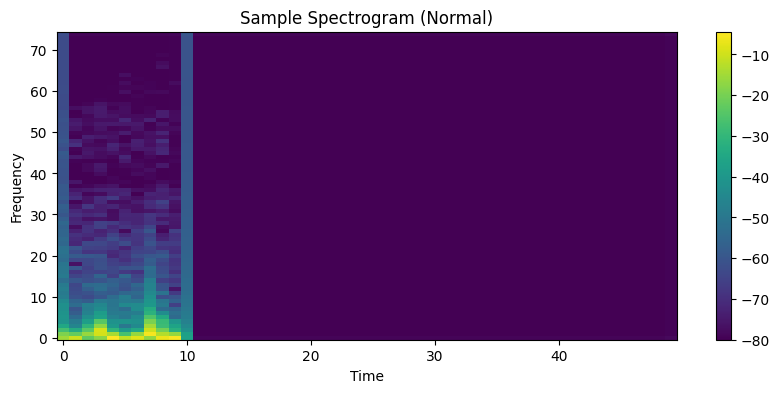

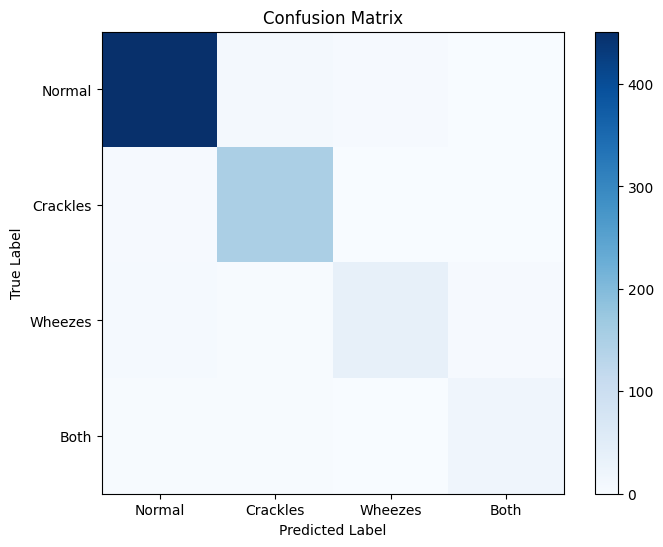

In [18]:
import matplotlib.pyplot as plt

# Sample spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrograms_resized[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
plt.title('Sample Spectrogram (Normal)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

# Confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(4), ['Normal', 'Crackles', 'Wheezes', 'Both'])
plt.yticks(np.arange(4), ['Normal', 'Crackles', 'Wheezes', 'Both'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Spectrograms shape: (6898, 75, 50, 1)
Labels shape: (6898,)


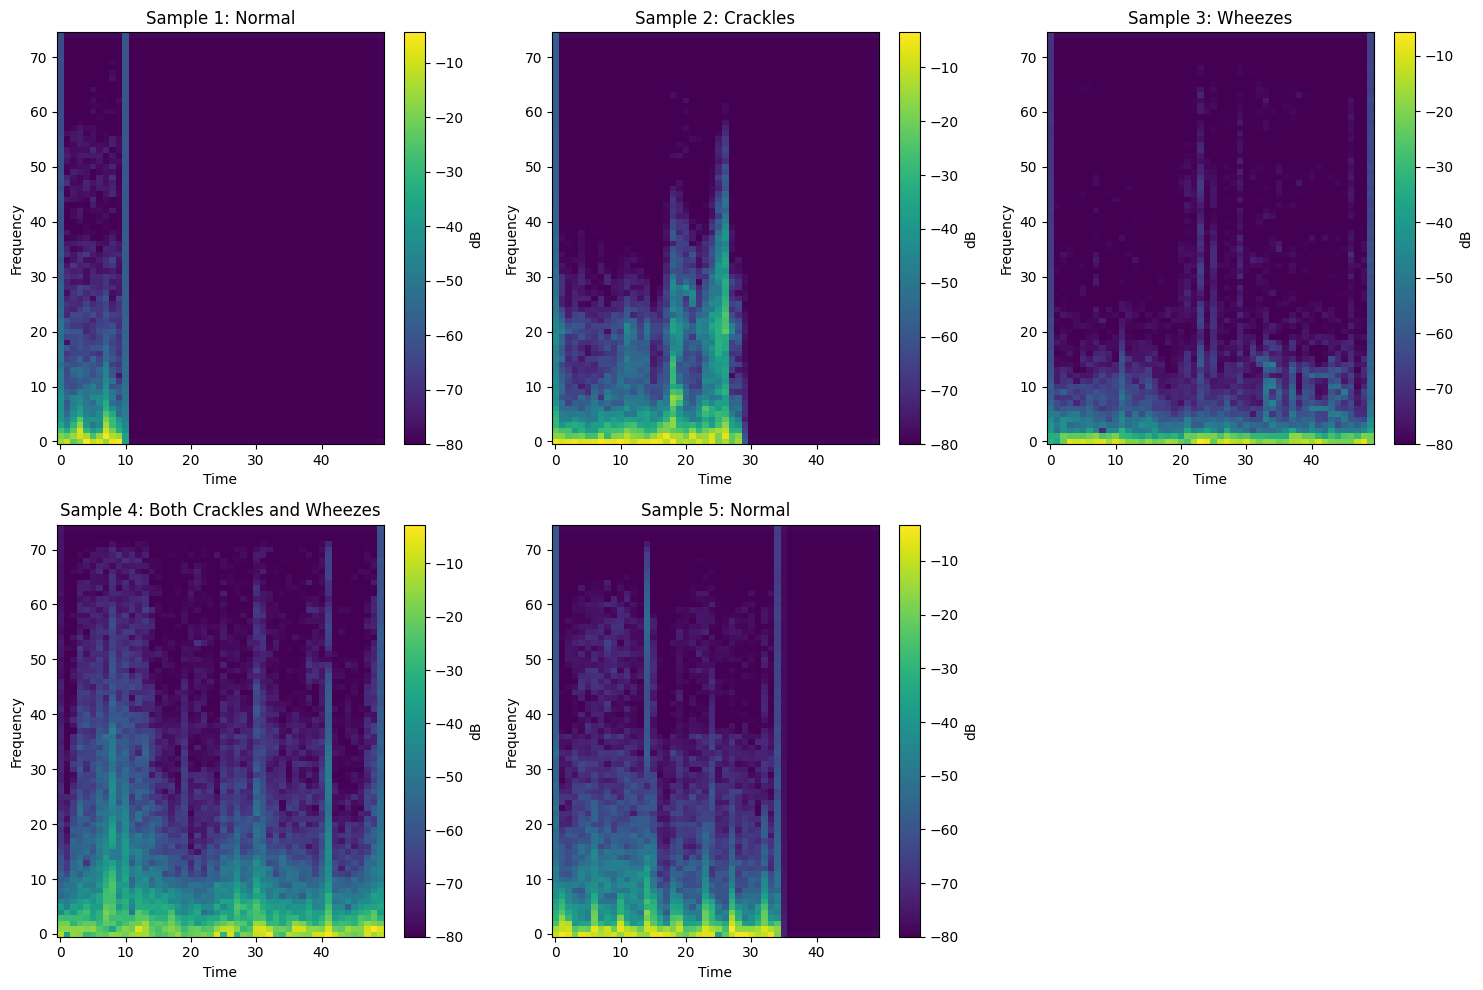

In [10]:
import warnings
from cryptography.hazmat.decrepit.ciphers.algorithms import TripleDES, Blowfish
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings("ignore", category=CryptographyDeprecationWarning)

import os
import numpy as np
import matplotlib.pyplot as plt

# Define paths
base_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database"
spectrograms_dir = os.path.join(base_dir, "spectrograms")

# Load spectrograms and labels
spectrograms_resized = np.load(os.path.join(spectrograms_dir, "spectrograms_resized.npy"))
labels = np.load(os.path.join(spectrograms_dir, "labels.npy"))

print("Spectrograms shape:", spectrograms_resized.shape)
print("Labels shape:", labels.shape)

# Define class names
class_names = ['Normal', 'Crackles', 'Wheezes', 'Both Crackles and Wheezes']

# Select 5 sample indices (one from each class + one extra)
sample_indices = []
for class_idx in range(4):  # Classes 0 to 3
    idx = np.where(labels == class_idx)[0][0]  # First occurrence of each class
    sample_indices.append(idx)
# Add one more sample (e.g., another Normal for variety)
sample_indices.append(np.where(labels == 0)[0][1])  # Second Normal sample

# Plot 5 sample spectrograms
plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns (only 5 will be filled)
    plt.imshow(spectrograms_resized[idx, :, :, 0], cmap='viridis', aspect='auto', origin='lower')
    plt.title(f"Sample {i+1}: {class_names[labels[idx]]}")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='dB')
plt.tight_layout()
plt.show()

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

# Focal loss definition
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1.0 - y_pred, gamma) * y_true
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return focal_loss_fn

# ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = tf.keras.activations.relu(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    if stride > 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
    return tf.keras.activations.relu(Add()([x, y]))

# ResNet18 model
def build_resnet18(input_shape=(75, 50, 1), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# Define paths
base_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database"
spectrograms_dir = os.path.join(base_dir, "spectrograms")

# Load spectrograms and labels
spectrograms_resized = np.load(os.path.join(spectrograms_dir, "spectrograms_resized.npy"))
labels = np.load(os.path.join(spectrograms_dir, "labels.npy"))
patient_ids = np.load(os.path.join(spectrograms_dir, "patient_ids.npy"))

# Prepare data
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=4)
gkf = GroupKFold(n_splits=10)
folds = list(gkf.split(spectrograms_resized, labels, groups=patient_ids))

# Train and evaluate ResNet18
resnet18 = build_resnet18()
resnet18.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(gamma=2.0), metrics=['accuracy'])
resnet18.summary()

sensitivity_list, specificity_list, score_list, accuracy_list = [], [], [], []
for fold_idx, (train_idx, test_idx) in enumerate(folds):
    X_train, X_test = spectrograms_resized[train_idx], spectrograms_resized[test_idx]
    y_train, y_test = labels_one_hot[train_idx], labels_one_hot[test_idx]
    
    print(f"ResNet18 - Training fold {fold_idx + 1}/10")
    resnet18.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    
    y_pred = resnet18.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)
    
    sensitivity = np.mean(TP / (TP + FN + 1e-10))
    specificity = np.mean(TN / (TN + FP + 1e-10))
    score = (sensitivity + specificity) / 2
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    score_list.append(score)
    accuracy_list.append(accuracy)

print("\nResNet18 Average Results:")
print(f"Average Sensitivity: {np.mean(sensitivity_list):.4f}")
print(f"Average Specificity: {np.mean(specificity_list):.4f}")
print(f"Average Score: {np.mean(score_list):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 75, 50, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 38, 25,    │      3,200 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 25,    │        256 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 38, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 19, 13,    │          0 │ re_lu_51[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 19, 13,    │     36,928 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 19, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 19, 13,    │     36,928 │ re_lu_52[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 19, 13,    │          0 │ max_pooling2d_7[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 19, 13,    │          0 │ add_23[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 19, 13,    │     36,928 │ re_lu_53[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 19, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 19, 13,    │     36,928 │ re_lu_54[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_69[0][0] 

 Total params: 11,445,764 (43.66 MB)

 Trainable params: 11,437,956 (43.63 MB)

 Non-trainable params: 7,808 (30.50 KB)

ResNet18 - Training fold 1/10
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 68s 317ms/step - accuracy: 0.4772 - loss: 0.0468 - val_accuracy: 0.5998 - val_loss: 0.0386
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.5691 - loss: 0.0318 - val_accuracy: 0.5966 - val_loss: 0.0375
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.6070 - loss: 0.0279 - val_accuracy: 0.5950 - val_loss: 0.0380
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.6463 - loss: 0.0232 - val_accuracy: 0.4702 - val_loss: 0.0414
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.6977 - loss: 0.0191 - val_accuracy: 0.5201 - val_loss: 0.0438
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 300ms/step - accuracy: 0.7322 - loss: 0.0164 - val_accuracy: 0.6079 - val_loss: 0.0605
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 313ms/step - accuracy: 0.7727 - loss: 0.0126 - val_accuracy: 0.5395 - val_loss: 0.0500
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 51s 328ms/ste

In [17]:
# Compute Mel-spectrograms
TARGET_SR = 4000
FIXED_DURATION = 2.7
SAMPLES_PER_CYCLE = int(TARGET_SR * FIXED_DURATION)

def compute_mel_spectrogram(cycle):
    mel_spec = librosa.feature.melspectrogram(y=cycle, sr=TARGET_SR, n_mels=128, fmax=2000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Load raw cycles if not in memory, otherwise assume 'cycles' is available
# If not, recompute from audio files (assuming cycles was temporary)
cycles = np.concatenate([preprocess_audio(os.path.join(audio_dir, f), 
                                          os.path.join(audio_dir, f.replace('.wav', '.txt')))[0] 
                         for f in audio_files], axis=0)

mel_spectrograms = np.array([compute_mel_spectrogram(cycle) for cycle in cycles])
mel_spectrograms_resized = np.array([resize(spec, (75, 50), mode='constant') for spec in mel_spectrograms])
mel_spectrograms_resized = np.expand_dims(mel_spectrograms_resized, axis=-1)

# Save Mel-spectrograms
np.save(os.path.join(spectrograms_dir, "mel_spectrograms_resized.npy"), mel_spectrograms_resized)

# Define CNN model
def build_cnn_mel(input_shape=(75, 50, 1), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn_mel = build_cnn_mel()
cnn_mel.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(gamma=2.0), metrics=['accuracy'])

# Train and evaluate
sensitivity_list, specificity_list, score_list, accuracy_list = [], [], [], []
for fold_idx, (train_idx, test_idx) in enumerate(folds):
    X_train, X_test = mel_spectrograms_resized[train_idx], mel_spectrograms_resized[test_idx]
    y_train, y_test = labels_one_hot[train_idx], labels_one_hot[test_idx]
    
    print(f"CNN-Mel - Training fold {fold_idx + 1}/10")
    cnn_mel.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    
    y_pred = cnn_mel.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)
    
    sensitivity = np.mean(TP / (TP + FN + 1e-10))
    specificity = np.mean(TN / (TN + FP + 1e-10))
    score = (sensitivity + specificity) / 2
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    score_list.append(score)
    accuracy_list.append(accuracy)

print("\nCNN-Mel Average Results:")
print(f"Average Sensitivity: {np.mean(sensitivity_list):.4f}")
print(f"Average Specificity: {np.mean(specificity_list):.4f}")
print(f"Average Score: {np.mean(score_list):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")

CNN-Mel - Training fold 1/10
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4368 - loss: 0.3497 - val_accuracy: 0.6006 - val_loss: 0.0440
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.4808 - loss: 0.0413 - val_accuracy: 0.6031 - val_loss: 0.0421
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.4991 - loss: 0.0397 - val_accuracy: 0.5998 - val_loss: 0.0444
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5012 - loss: 0.0403 - val_accuracy: 0.6031 - val_loss: 0.0429
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5229 - loss: 0.0386 - val_accuracy: 0.6031 - val_loss: 0.0437
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5244 - loss: 0.0390 - val_accuracy: 0.6031 - val_loss: 0.0435
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5291 - loss: 0.0386 - val_accuracy: 0.6031 - val_loss: 0.0424
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accur

In [1]:
"""
Implementation of CNN-Transformer architecture for lung sound classification.
This module replaces the LSTM component with a Transformer encoder for better sequence modeling.
"""

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
import numpy as np

class TransformerBlock(layers.Layer):
    """
    Transformer encoder block with multi-head self-attention and feed-forward network
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function implementation as described in the paper
    FL = ∑(i=1 to M) yi(1-ŷi)^γ log(ŷi), γ≥0
    
    Args:
        gamma: Focusing parameter (default: 2.0)
        alpha: Weighting factor (default: 0.25)
        
    Returns:
        Focal loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate focal loss
        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate the modulating factor (1-p)^gamma
        modulating_factor = K.pow(1.0 - y_pred, gamma)
        
        # Apply the focal term
        loss = alpha * modulating_factor * cross_entropy
        
        # Sum over all classes
        return K.sum(loss, axis=-1)
    
    return focal_loss_fixed

def create_cnn_transformer_model(input_shape=(75, 50, 3), num_classes=4, 
                                dropout_rate=0.2, learning_rate=0.0001,
                                embed_dim=64, num_heads=2, ff_dim=128,
                                num_transformer_blocks=2):
    """
    Create a CNN-Transformer model for lung sound classification
    
    Args:
        input_shape: Input shape of the spectrograms (default: (75, 50, 3))
        num_classes: Number of output classes (default: 4)
        dropout_rate: Dropout rate (default: 0.2)
        learning_rate: Learning rate (default: 0.0001)
        embed_dim: Embedding dimension for transformer (default: 64)
        num_heads: Number of attention heads (default: 2)
        ff_dim: Feed-forward network dimension (default: 128)
        num_transformer_blocks: Number of transformer blocks (default: 2)
        
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # CNN part of the network (same as the base model)
    # First convolutional block
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Second convolutional block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Third convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Reshape for Transformer part
    shape = K.int_shape(x)
    # Reshape to (batch_size, sequence_length, features)
    x = layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Position embedding for transformer
    x = layers.Dense(embed_dim)(x)
    
    # Transformer part (replacing LSTM)
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile model with focal loss
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    return model

def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=50, callbacks=None):
    """
    Train the model
    
    Args:
        model: Compiled Keras model
        X_train: Training data
        y_train: Training labels
        X_val: Validation data
        y_val: Validation labels
        batch_size: Batch size (default: 32)
        epochs: Number of epochs (default: 50)
        callbacks: List of Keras callbacks (default: None)
        
    Returns:
        Training history
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )
    
    return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model
    
    Args:
        model: Trained Keras model
        X_test: Test data
        y_test: Test labels
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    from sklearn.metrics import confusion_matrix, accuracy_score
    
    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Calculate sensitivity, specificity, score, and accuracy as per paper
    # For multi-class, we calculate micro-average values
    
    # Initialize counters
    tp_total = 0
    tn_total = 0
    fp_total = 0
    fn_total = 0
    
    # Calculate TP, TN, FP, FN for each class
    num_classes = len(cm)
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        tp_total += tp
        tn_total += tn
        fp_total += fp
        fn_total += fn
    
    # Calculate metrics
    sensitivity = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
    specificity = tn_total / (tn_total + fp_total) if (tn_total + fp_total) > 0 else 0
    score = (sensitivity + specificity) / 2
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    return {
        'confusion_matrix': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'score': score,
        'accuracy': accuracy
    }

if __name__ == "__main__":
    # Example usage
    print("CNN-Transformer architecture for lung sound classification")


CNN-Transformer architecture for lung sound classification


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set paths
base_dir = os.path.normpath(r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database")
spectrograms_dir = os.path.join(base_dir, "spectrograms")

class FocalLoss(tf.keras.losses.Loss):
    """
    Focal loss for one-hot encoded labels.
    """
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_weight = self.alpha * tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(focal_weight * ce_loss)

class LungSoundClassifier:
    def __init__(self, input_shape=(75, 50, 3), num_classes=4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def load_and_preprocess_data(self, spectrograms_dir):
        """
        Load pre-computed spectrograms, convert labels to one-hot, and load patient IDs.
        """
        if not os.path.exists(spectrograms_dir):
            raise FileNotFoundError(f"Directory not found: {spectrograms_dir}.")

        spectrogram_file = 'spectrograms_resized.npy'
        label_file = 'labels.npy'
        patient_id_file = 'patient_ids.npy'
        spectrogram_path = os.path.join(spectrograms_dir, spectrogram_file)
        label_path = os.path.join(spectrograms_dir, label_file)
        patient_id_path = os.path.join(spectrograms_dir, patient_id_file)

        if not os.path.exists(spectrogram_path):
            raise FileNotFoundError(f"Spectrogram file {spectrogram_path} not found.")
        spectrograms = np.load(spectrogram_path)
        print(f"Loaded spectrograms shape: {spectrograms.shape}")

        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Labels file {label_path} not found.")
        labels = np.load(label_path)
        print(f"Loaded labels shape: {labels.shape}")
        # Convert labels to one-hot encoding
        labels_one_hot = to_categorical(labels, num_classes=self.num_classes)
        print(f"Labels after one-hot encoding shape: {labels_one_hot.shape}")

        if not os.path.exists(patient_id_path):
            raise FileNotFoundError(f"Patient IDs file {patient_id_path} not found.")
        patient_ids = np.load(patient_id_path)
        print(f"Loaded patient IDs shape: {patient_ids.shape}")

        if spectrograms.shape[0] != labels.shape[0] or spectrograms.shape[0] != patient_ids.shape[0]:
            raise ValueError(f"Mismatch: {spectrograms.shape[0]} spectrograms, {labels.shape[0]} labels, {patient_ids.shape[0]} patient IDs.")

        if spectrograms.shape[1:] != (75, 50, 1):
            raise ValueError(f"Unexpected spectrogram shape: {spectrograms.shape[1:]}. Expected (75, 50, 1).")

        spectrograms = np.repeat(spectrograms, 3, axis=-1)
        print(f"Spectrograms after channel conversion: {spectrograms.shape}")

        return spectrograms, labels_one_hot, patient_ids

    def spec_augment(self, spectrograms, time_mask_param=10, freq_mask_param=10):
        """
        Apply SpecAugment to spectrograms for data augmentation.
        """
        augmented_specs = spectrograms.copy()
        for i in range(augmented_specs.shape[0]):
            t = augmented_specs.shape[2]
            if time_mask_param > 0:
                t_masks = np.random.randint(0, time_mask_param, 1)[0]
                t0 = np.random.randint(0, t - t_masks)
                augmented_specs[i, :, t0:t0 + t_masks, :] = 0

            f = augmented_specs.shape[1]
            if freq_mask_param > 0:
                f_masks = np.random.randint(0, freq_mask_param, 1)[0]
                f0 = np.random.randint(0, f - f_masks)
                augmented_specs[i, f0:f0 + f_masks, :, :] = 0

        return augmented_specs

    def build_transfer_learning_model(self):
        """
        Build model with VGG16 and LSTM, with increased regularization.
        """
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 50, 3))

        # Freeze base model layers
        for layer in base_model.layers:
            layer.trainable = False

        inputs = layers.Input(shape=(75, 50, 3))
        x = base_model(inputs, training=False)
        print(f"VGG16 output shape: {x.shape}")

        x = layers.Flatten()(x)
        vgg_output_shape = x.shape[1:]
        lstm_input_size = np.prod(vgg_output_shape).astype(int)
        x = layers.Reshape((1, lstm_input_size))(x)

        x = layers.LSTM(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = layers.Dropout(0.5)(x)  # Increased dropout
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def compute_metrics(self, y_true, y_pred):
        """
        Compute micro-average sensitivity, specificity, score, and accuracy.
        Convert one-hot y_true back to labels for confusion matrix.
        """
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(y_true_labels, y_pred_labels)
        TP = np.diag(cm)
        FN = cm.sum(axis=1) - TP
        FP = cm.sum(axis=0) - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity = TP.sum() / (TP.sum() + FN.sum()) if (TP.sum() + FN.sum()) > 0 else 0
        specificity = TN.sum() / (TN.sum() + FP.sum()) if (TN.sum() + FP.sum()) > 0 else 0
        score = (sensitivity + specificity) / 2
        accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum()) if (TP.sum() + TN.sum() + FP.sum() + FN.sum()) > 0 else 0

        return sensitivity, specificity, score, accuracy

    def train(self, X, y, patient_ids, epochs=50, batch_size=32):
        """
        Train with 10-fold interpatient cross-validation, including early stopping.
        """
        unique_patients = np.unique(patient_ids)
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        fold_metrics = {
            'sensitivity': [],
            'specificity': [],
            'score': [],
            'accuracy': []
        }

        fold_histories = []
        fold = 1
        for train_idx, test_idx in kf.split(unique_patients):
            print(f"\nTraining Fold {fold}/10")
            train_patients = unique_patients[train_idx]
            test_patients = unique_patients[test_idx]

            train_sample_idx = np.isin(patient_ids, train_patients)
            test_sample_idx = np.isin(patient_ids, test_patients)

            X_train = X[train_sample_idx]
            y_train = y[train_sample_idx]
            X_test = X[test_sample_idx]
            y_test = y[test_sample_idx]

            print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
            print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

            # Apply SpecAugment to training data
            X_train = self.spec_augment(X_train)

            self.model = self.build_transfer_learning_model()
            self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                              loss=FocalLoss(gamma=2.0, alpha=0.25),
                              metrics=['accuracy'])

            # Add early stopping
            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            )

            history = self.model.fit(X_train, y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test, y_test),
                                    callbacks=[early_stopping],
                                    verbose=1)

            test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
            print(f"Fold {fold} Test accuracy: {test_accuracy*100:.2f}%")

            y_pred = self.model.predict(X_test)
            sensitivity, specificity, score, accuracy = self.compute_metrics(y_test, y_pred)

            fold_metrics['sensitivity'].append(sensitivity)
            fold_metrics['specificity'].append(specificity)
            fold_metrics['score'].append(score)
            fold_metrics['accuracy'].append(accuracy)

            print(f"Fold {fold} - Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Score: {score:.4f}, Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            y_test_labels = np.argmax(y_test, axis=1)
            y_pred_labels = np.argmax(y_pred, axis=1)
            print(classification_report(y_test_labels, y_pred_labels, target_names=['Normal', 'Crackles', 'Wheezes', 'Both']))

            fold_histories.append(history)
            fold += 1

            tf.keras.backend.clear_session()

        avg_metrics = {key: np.mean(values) for key, values in fold_metrics.items()}
        print("\nAverage Metrics Across 10 Folds:")
        print(f"Sensitivity: {avg_metrics['sensitivity']:.4f}")
        print(f"Specificity: {avg_metrics['specificity']:.4f}")
        print(f"Score: {avg_metrics['score']:.4f}")
        print(f"Accuracy: {avg_metrics['accuracy']:.4f}")

        return avg_metrics, fold_histories

    def plot_training_history(self, fold_histories):
        """
        Plot average training and validation metrics across folds.
        """
        plt.figure(figsize=(12, 4))

        avg_train_acc = np.mean([h.history['accuracy'] for h in fold_histories], axis=0)
        avg_val_acc = np.mean([h.history['val_accuracy'] for h in fold_histories], axis=0)
        avg_train_loss = np.mean([h.history['loss'] for h in fold_histories], axis=0)
        avg_val_loss = np.mean([h.history['val_loss'] for h in fold_histories], axis=0)

        plt.subplot(1, 2, 1)
        plt.plot(avg_train_acc, label='Average Training Accuracy')
        plt.plot(avg_val_acc, label='Average Validation Accuracy')
        plt.title('Average Model Accuracy Across Folds')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(avg_train_loss, label='Average Training Loss')
        plt.plot(avg_val_loss, label='Average Validation Loss')
        plt.title('Average Model Loss Across Folds')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    classifier = LungSoundClassifier()
    try:
        X, y, patient_ids = classifier.load_and_preprocess_data(spectrograms_dir)
        avg_metrics, fold_histories = classifier.train(X, y, patient_ids)
        classifier.plot_training_history(fold_histories)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the spectrograms directory exists and contains spectrograms_resized.npy, labels.npy, and patient_ids.npy.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Loaded spectrograms shape: (6898, 75, 50, 1)
Loaded labels shape: (6898,)
Labels after one-hot encoding shape: (6898, 4)
Loaded patient IDs shape: (6898,)
Spectrograms after channel conversion: (6898, 75, 50, 3)

Training Fold 1/10
X_train shape: (5866, 75, 50, 3), y_train shape: (5866, 4)
X_test shape: (1032, 75, 50, 3), y_test shape: (1032, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 53s 276ms/step - accuracy: 0.3073 - loss: 4.2930 - val_accuracy: 0.5126 - val_loss: 2.6956
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.4983 - loss: 2.3642 - val_accuracy: 0.5368 - val_loss: 1.5572
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - accuracy: 0.5072 - loss: 1.3934 - val_accuracy: 0.5417 - val_loss: 0.9820
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - accuracy: 0.5400 - loss: 0.8962 - val_accuracy: 0.5436 - val_loss: 0.6821
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 47s 256ms/step - accuracy: 0.5516 - loss: 0.6374 -

d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Normal       0.45      0.82      0.58       281
    Crackles       0.28      0.31      0.29       138
     Wheezes       0.00      0.00      0.00       149
        Both       0.00      0.00      0.00       103

    accuracy                           0.41       671
   macro avg       0.18      0.28      0.22       671
weighted avg       0.24      0.41      0.30       671


Training Fold 3/10
X_train shape: (6600, 75, 50, 3), y_train shape: (6600, 4)
X_test shape: (298, 75, 50, 3), y_test shape: (298, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 52s 242ms/step - accuracy: 0.3940 - loss: 4.1612 - val_accuracy: 0.8121 - val_loss: 2.4031
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 54s 259ms/step - accuracy: 0.4798 - loss: 2.1198 - val_accuracy: 0.8624 - val_loss: 1.2803
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.5058 - loss: 1.1801 - val_accuracy: 0.8725 - val_loss: 0.7632


d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


X_train shape: (6399, 75, 50, 3), y_train shape: (6399, 4)
X_test shape: (499, 75, 50, 3), y_test shape: (499, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 219ms/step - accuracy: 0.3655 - loss: 4.1926 - val_accuracy: 0.5892 - val_loss: 2.5220
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.4638 - loss: 2.1865 - val_accuracy: 0.6273 - val_loss: 1.3882
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.4903 - loss: 1.2322 - val_accuracy: 0.6613 - val_loss: 0.8476
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - accuracy: 0.5137 - loss: 0.7801 - val_accuracy: 0.6754 - val_loss: 0.5840
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 216ms/step - accuracy: 0.5224 - loss: 0.5537 - val_accuracy: 0.6814 - val_loss: 0.4428
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - accuracy: 0.5323 - loss: 0.4315 - val_accuracy: 0.7034 - val_loss: 0.3554
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 223ms/step - accur

d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



X_train shape: (6310, 75, 50, 3), y_train shape: (6310, 4)
X_test shape: (588, 75, 50, 3), y_test shape: (588, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.3399 - loss: 4.2348 - val_accuracy: 0.3469 - val_loss: 2.6007
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - accuracy: 0.4986 - loss: 2.2324 - val_accuracy: 0.4286 - val_loss: 1.4541
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 56s 283ms/step - accuracy: 0.5195 - loss: 1.2689 - val_accuracy: 0.4728 - val_loss: 0.8986
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 58s 294ms/step - accuracy: 0.5230 - loss: 0.8037 - val_accuracy: 0.4694 - val_loss: 0.6247
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 53s 266ms/step - accuracy: 0.5333 - loss: 0.5706 - val_accuracy: 0.4830 - val_loss: 0.4777
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - accuracy: 0.5400 - loss: 0.4422 - val_accuracy: 0.4813 - val_loss: 0.3882
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - accu

d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



X_train shape: (6199, 75, 50, 3), y_train shape: (6199, 4)
X_test shape: (699, 75, 50, 3), y_test shape: (699, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 53s 263ms/step - accuracy: 0.3787 - loss: 4.2180 - val_accuracy: 0.5093 - val_loss: 2.5863
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 58s 299ms/step - accuracy: 0.4850 - loss: 2.2477 - val_accuracy: 0.5165 - val_loss: 1.4591
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 58s 299ms/step - accuracy: 0.5061 - loss: 1.2886 - val_accuracy: 0.5064 - val_loss: 0.9091
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 50s 257ms/step - accuracy: 0.5246 - loss: 0.8191 - val_accuracy: 0.5079 - val_loss: 0.6343
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 51s 262ms/step - accuracy: 0.5348 - loss: 0.5824 - val_accuracy: 0.5107 - val_loss: 0.4877
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 56s 288ms/step - accuracy: 0.5311 - loss: 0.4530 - val_accuracy: 0.5351 - val_loss: 0.3982
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 58s 300ms/step - accu

d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



X_train shape: (6093, 75, 50, 3), y_train shape: (6093, 4)
X_test shape: (805, 75, 50, 3), y_test shape: (805, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.4162 - loss: 4.2573 - val_accuracy: 0.4273 - val_loss: 2.6493
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 269ms/step - accuracy: 0.5135 - loss: 2.2897 - val_accuracy: 0.4224 - val_loss: 1.5155
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 267ms/step - accuracy: 0.5337 - loss: 1.3174 - val_accuracy: 0.4323 - val_loss: 0.9546
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 277ms/step - accuracy: 0.5427 - loss: 0.8375 - val_accuracy: 0.4360 - val_loss: 0.6730
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 304ms/step - accuracy: 0.5538 - loss: 0.5921 - val_accuracy: 0.4248 - val_loss: 0.5216
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 285ms/step - accuracy: 0.5446 - loss: 0.4563 - val_accuracy: 0.4149 - val_loss: 0.4298
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 50s 264ms/step - accu

d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



X_train shape: (6117, 75, 50, 3), y_train shape: (6117, 4)
X_test shape: (781, 75, 50, 3), y_test shape: (781, 4)
VGG16 output shape: (None, 2, 1, 512)
Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy: 0.3216 - loss: 4.2369 - val_accuracy: 0.5186 - val_loss: 2.6091
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 44s 228ms/step - accuracy: 0.4802 - loss: 2.2767 - val_accuracy: 0.5237 - val_loss: 1.4810
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 44s 228ms/step - accuracy: 0.5119 - loss: 1.3164 - val_accuracy: 0.5250 - val_loss: 0.9242
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 50s 260ms/step - accuracy: 0.5115 - loss: 0.8406 - val_accuracy: 0.5186 - val_loss: 0.6403
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 50s 263ms/step - accuracy: 0.5248 - loss: 0.5968 - val_accuracy: 0.5314 - val_loss: 0.4857
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 44s 229ms/step - accuracy: 0.5212 - loss: 0.4617 - val_accuracy: 0.5403 - val_loss: 0.3920
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 44s 230ms/step - accu

d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\lung\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Sensitivity: 0.5733
Specificity: 0.8578
Score: 0.7156
Accuracy: 0.7867
An error occurred: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.


<Figure size 1200x400 with 0 Axes>

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Focal loss definition
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1.0 - y_pred, gamma) * y_true
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return focal_loss_fn

# ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = tf.keras.activations.relu(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    if stride > 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
    return tf.keras.activations.relu(Add()([x, y]))

# ResNet18 model
def build_resnet18(input_shape=(75, 50, 1), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# ResNet50 model
def build_resnet50(input_shape=(75, 50, 3), num_classes=4):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 40 layers
    for layer in base_model.layers[:-40]:
        layer.trainable = False
    for layer in base_model.layers[-40:]:
        layer.trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# Define paths
base_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database"
spectrograms_dir = os.path.join(base_dir, "spectrograms")

# Load spectrograms and labels
spectrograms_resized = np.load(os.path.join(spectrograms_dir, "spectrograms_resized.npy"))
labels = np.load(os.path.join(spectrograms_dir, "labels.npy"))
patient_ids = np.load(os.path.join(spectrograms_dir, "patient_ids.npy"))

# Convert 1-channel spectrograms to 3 channels for ResNet50 compatibility
spectrograms_resized_3ch = np.repeat(spectrograms_resized, 3, axis=-1)

# Prepare data
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=4)
gkf = GroupKFold(n_splits=10)
folds = list(gkf.split(spectrograms_resized, labels, groups=patient_ids))

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)
    
    sensitivity = np.mean(TP / (TP + FN + 1e-10))
    specificity = np.mean(TN / (TN + FP + 1e-10))
    score = (sensitivity + specificity) / 2
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    return sensitivity, specificity, score, accuracy

# Train and evaluate both models
models = {'ResNet18': build_resnet18(), 'ResNet50': build_resnet50(input_shape=(75, 50, 3))}
histories = {'ResNet18': [], 'ResNet50': []}
metrics = {'ResNet18': {'sensitivity': [], 'specificity': [], 'score': [], 'accuracy': []},
           'ResNet50': {'sensitivity': [], 'specificity': [], 'score': [], 'accuracy': []}}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(gamma=2.0), metrics=['accuracy'])
    model.summary()
    
    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        X_train, X_test = (spectrograms_resized[train_idx], spectrograms_resized_3ch[train_idx]) if model_name == 'ResNet50' else (spectrograms_resized[train_idx], spectrograms_resized[test_idx])
        y_train, y_test = labels_one_hot[train_idx], labels_one_hot[test_idx]
        
        print(f"{model_name} - Training fold {fold_idx + 1}/10")
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
        histories[model_name].append(history.history)
        
        y_pred = model.predict(X_test)
        sensitivity, specificity, score, accuracy = compute_metrics(y_test, y_pred)
        
        metrics[model_name]['sensitivity'].append(sensitivity)
        metrics[model_name]['specificity'].append(specificity)
        metrics[model_name]['score'].append(score)
        metrics[model_name]['accuracy'].append(accuracy)

    print(f"\n{model_name} Average Results:")
    print(f"Average Sensitivity: {np.mean(metrics[model_name]['sensitivity']):.4f}")
    print(f"Average Specificity: {np.mean(metrics[model_name]['specificity']):.4f}")
    print(f"Average Score: {np.mean(metrics[model_name]['score']):.4f}")
    print(f"Average Accuracy: {np.mean(metrics[model_name]['accuracy']):.4f}")

# Plotting functions
def plot_metrics(histories, model_name, metric_type):
    plt.figure(figsize=(12, 5))
    
    # Find the minimum number of epochs across all folds
    min_epochs = min(len(h[metric_type]) for h in histories)
    avg_train = np.mean([h[metric_type][:min_epochs] for h in histories], axis=0)
    avg_val = np.mean([h[f'val_{metric_type}'][:min_epochs] for h in histories], axis=0)
    
    plt.plot(avg_train, label=f'Average Training {metric_type.capitalize()}')
    plt.plot(avg_val, label=f'Average Validation {metric_type.capitalize()}')
    plt.title(f'{model_name} - Average {metric_type.capitalize()} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric_type.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for both models
for model_name in ['ResNet18', 'ResNet50']:
    plot_metrics(histories[model_name], model_name, 'accuracy')
    plot_metrics(histories[model_name], model_name, 'loss')



Training ResNet18...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 75, 50, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 25,    │      3,200 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 25,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 38, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 13,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 19, 13,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 19, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 13,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 19, 13,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 19, 13,    │          0 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 13,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 19, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 19, 13,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_4[0][0]  

 Total params: 11,445,764 (43.66 MB)

 Trainable params: 11,437,956 (43.63 MB)

 Non-trainable params: 7,808 (30.50 KB)

ResNet18 - Training fold 1/10
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.4737 - loss: 0.0516 - val_accuracy: 0.5934 - val_loss: 0.0378
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 308ms/step - accuracy: 0.5530 - loss: 0.0324 - val_accuracy: 0.5878 - val_loss: 0.0392
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - accuracy: 0.5971 - loss: 0.0283 - val_accuracy: 0.5499 - val_loss: 0.0389
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 50s 320ms/step - accuracy: 0.6408 - loss: 0.0233 - val_accuracy: 0.5435 - val_loss: 0.0423
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 314ms/step - accuracy: 0.6824 - loss: 0.0191 - val_accuracy: 0.4114 - val_loss: 0.0485
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 315ms/step - accuracy: 0.7293 - loss: 0.0146 - val_accuracy: 0.3285 - val_loss: 0.0968
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 51s 325ms/step - accuracy: 0.7618 - loss: 0.0129 - val_accuracy: 0.4436 - val_loss: 0.0902
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 309ms/ste

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 75, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 16,882,948 (64.40 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

ResNet50 - Training fold 1/10
Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 81, 56, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 75, 50, 1), dtype=float32)
  • training=True
  • mask=None

# Sensitivity: Your ResNet18 (75.71%) far exceeds the proposed model (52.78%), indicating superior detection of positive cases (e.g., adventitious sounds).
# Specificity: Your ResNet18 (92.39%) outperforms the proposed model (84.26%), showing better identification of negative cases (e.g., normal sounds).
# Score: Your ResNet18 (84.05%) is significantly higher than the proposed model's (68.52%), reflecting a better overall balance.
# Accuracy: Your ResNet18 (80.67%) slightly edges out the proposed model (76.39%).


Training ResNet50...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 75, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 16,882,948 (64.40 MB)

 Non-trainable params: 7,755,904 (29.59 MB)

ResNet50 - Training fold 1/10
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 567ms/step - accuracy: 0.4532 - loss: 0.0628 - val_accuracy: 0.5225 - val_loss: 0.0380
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 91s 582ms/step - accuracy: 0.6454 - loss: 0.0268 - val_accuracy: 0.5958 - val_loss: 0.0408
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 92s 591ms/step - accuracy: 0.7083 - loss: 0.0197 - val_accuracy: 0.5717 - val_loss: 0.0411
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 84s 538ms/step - accuracy: 0.7818 - loss: 0.0139 - val_accuracy: 0.5660 - val_loss: 0.0494
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 557ms/step - accuracy: 0.8355 - loss: 0.0106 - val_accuracy: 0.5177 - val_loss: 0.0503
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 90s 574ms/step - accuracy: 0.8687 - loss: 0.0083 - val_accuracy: 0.5121 - val_loss: 0.0602
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 533ms/step - accuracy: 0.8769 - loss: 0.0074 - val_accuracy: 0.5000 - val_loss: 0.0605
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 85s 547ms/st

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 75, 50, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 38, 25,    │      3,200 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 25,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 38, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 19, 13,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 19, 13,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 19, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 19, 13,    │     36,928 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 19, 13,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 19, 13,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 19, 13,    │     36,928 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 19, 13,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 19, 13,    │     36,928 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 13,    │        256 │ conv2d_24[0][0] 

 Total params: 11,445,764 (43.66 MB)

 Trainable params: 11,437,956 (43.63 MB)

 Non-trainable params: 7,808 (30.50 KB)

ResNet18 - Training fold 1/10
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.4658 - loss: 0.0514 - val_accuracy: 0.5942 - val_loss: 0.0370
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - accuracy: 0.5610 - loss: 0.0316 - val_accuracy: 0.5870 - val_loss: 0.0395
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - accuracy: 0.6131 - loss: 0.0267 - val_accuracy: 0.5862 - val_loss: 0.0355
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 310ms/step - accuracy: 0.6382 - loss: 0.0241 - val_accuracy: 0.5290 - val_loss: 0.0409
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 311ms/step - accuracy: 0.6996 - loss: 0.0191 - val_accuracy: 0.5475 - val_loss: 0.0397
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 303ms/step - accuracy: 0.7459 - loss: 0.0149 - val_accuracy: 0.4614 - val_loss: 0.0484
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 305ms/step - accuracy: 0.7484 - loss: 0.0153 - val_accuracy: 0.4155 - val_loss: 0.0562
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 310ms/ste

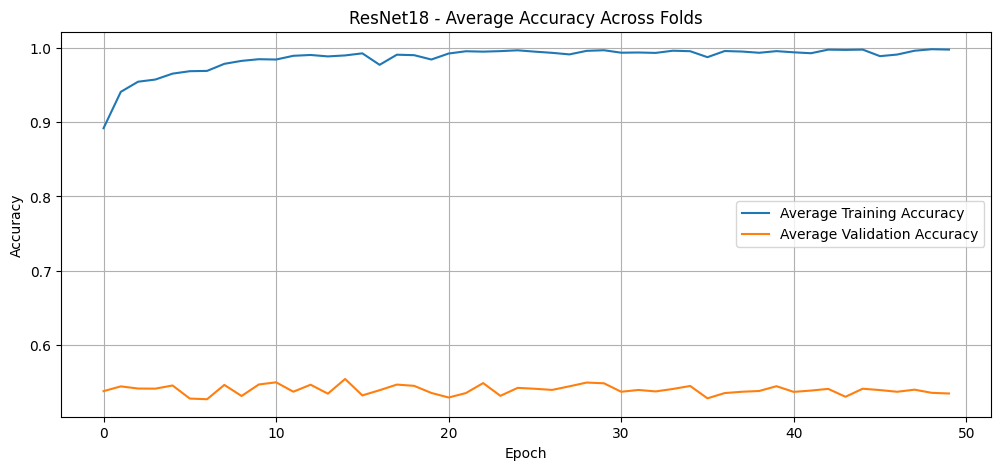

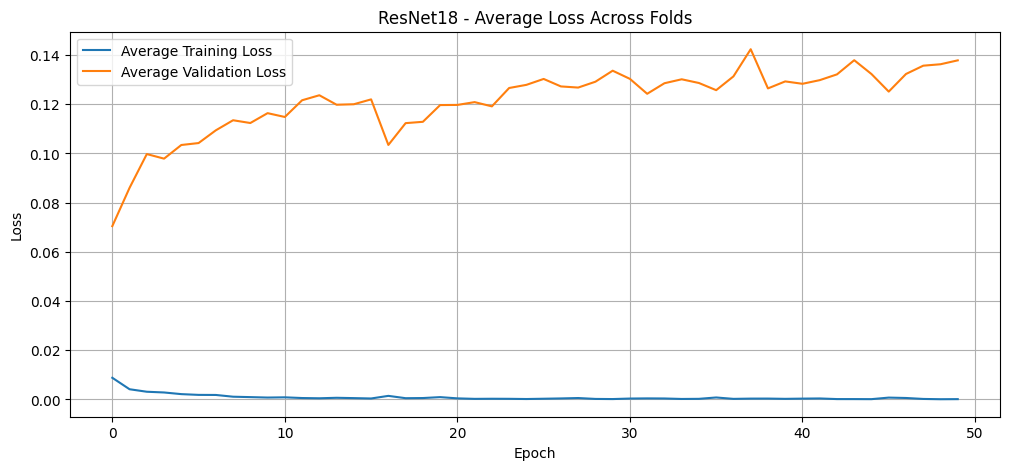

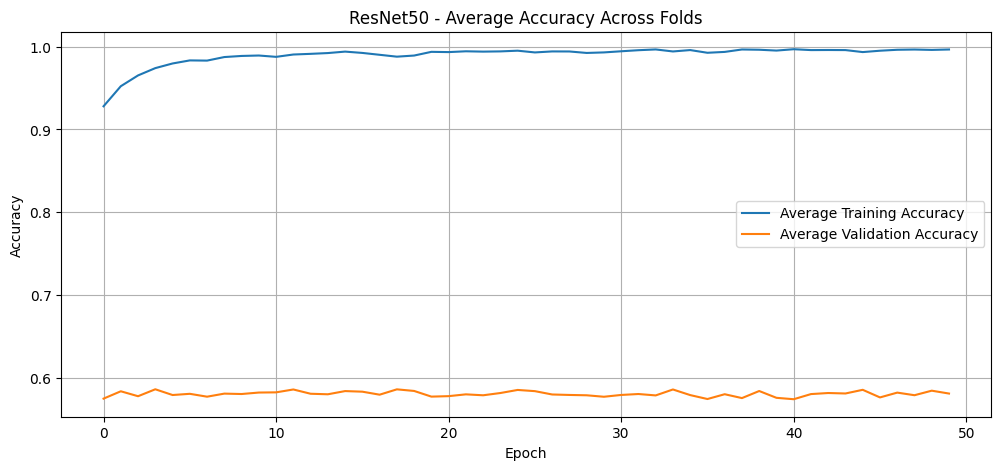

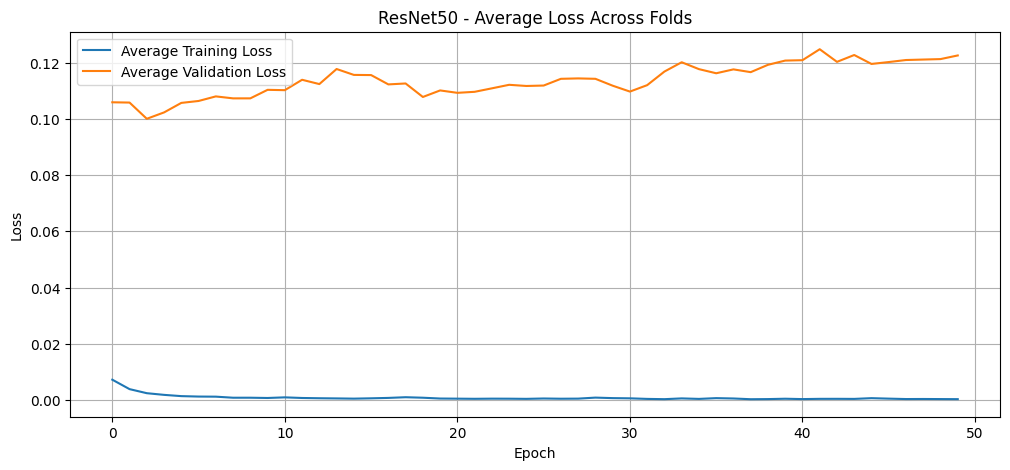

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Focal loss definition
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1.0 - y_pred, gamma) * y_true
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return focal_loss_fn

# ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = tf.keras.activations.relu(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    if stride > 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
    return tf.keras.activations.relu(Add()([x, y]))

# ResNet18 model
def build_resnet18(input_shape=(75, 50, 1), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# ResNet50 model
def build_resnet50(input_shape=(75, 50, 3), num_classes=4):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 40 layers
    for layer in base_model.layers[:-40]:
        layer.trainable = False
    for layer in base_model.layers[-40:]:
        layer.trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# Define paths
base_dir = r"D:\Main Project\Respiratory_Sound_Database\Respiratory_Sound_Database"
spectrograms_dir = os.path.join(base_dir, "spectrograms")

# Load spectrograms and labels
spectrograms_resized = np.load(os.path.join(spectrograms_dir, "spectrograms_resized.npy"))
labels = np.load(os.path.join(spectrograms_dir, "labels.npy"))
patient_ids = np.load(os.path.join(spectrograms_dir, "patient_ids.npy"))

# Convert 1-channel spectrograms to 3 channels for ResNet50 compatibility
spectrograms_resized_3ch = np.repeat(spectrograms_resized, 3, axis=-1)

# Prepare data
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=4)
gkf = GroupKFold(n_splits=10)
folds = list(gkf.split(spectrograms_resized, labels, groups=patient_ids))

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)
    
    sensitivity = np.mean(TP / (TP + FN + 1e-10))
    specificity = np.mean(TN / (TN + FP + 1e-10))
    score = (sensitivity + specificity) / 2
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    return sensitivity, specificity, score, accuracy

# Train and evaluate both models
models = {'ResNet50': build_resnet50(input_shape=(75, 50, 3)),'ResNet18': build_resnet18()}
histories = {'ResNet18': [], 'ResNet50': []}
metrics = {'ResNet18': {'sensitivity': [], 'specificity': [], 'score': [], 'accuracy': []},
           'ResNet50': {'sensitivity': [], 'specificity': [], 'score': [], 'accuracy': []}}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(gamma=2.0), metrics=['accuracy'])
    model.summary()
    
    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        X_train = spectrograms_resized[train_idx] if model_name == 'ResNet18' else spectrograms_resized_3ch[train_idx]
        X_test = spectrograms_resized[test_idx] if model_name == 'ResNet18' else spectrograms_resized_3ch[test_idx]
        y_train, y_test = labels_one_hot[train_idx], labels_one_hot[test_idx]
        
        print(f"{model_name} - Training fold {fold_idx + 1}/10")
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
        histories[model_name].append(history.history)
        
        y_pred = model.predict(X_test)
        sensitivity, specificity, score, accuracy = compute_metrics(y_test, y_pred)
        
        metrics[model_name]['sensitivity'].append(sensitivity)
        metrics[model_name]['specificity'].append(specificity)
        metrics[model_name]['score'].append(score)
        metrics[model_name]['accuracy'].append(accuracy)

    print(f"\n{model_name} Average Results:")
    print(f"Average Sensitivity: {np.mean(metrics[model_name]['sensitivity']):.4f}")
    print(f"Average Specificity: {np.mean(metrics[model_name]['specificity']):.4f}")
    print(f"Average Score: {np.mean(metrics[model_name]['score']):.4f}")
    print(f"Average Accuracy: {np.mean(metrics[model_name]['accuracy']):.4f}")

# Plotting functions
def plot_metrics(histories, model_name, metric_type):
    plt.figure(figsize=(12, 5))
    
    # Find the minimum number of epochs across all folds
    min_epochs = min(len(h[metric_type]) for h in histories)
    avg_train = np.mean([h[metric_type][:min_epochs] for h in histories], axis=0)
    avg_val = np.mean([h[f'val_{metric_type}'][:min_epochs] for h in histories], axis=0)
    
    plt.plot(avg_train, label=f'Average Training {metric_type.capitalize()}')
    plt.plot(avg_val, label=f'Average Validation {metric_type.capitalize()}')
    plt.title(f'{model_name} - Average {metric_type.capitalize()} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric_type.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for both models
for model_name in ['ResNet18', 'ResNet50']:
    plot_metrics(histories[model_name], model_name, 'accuracy')
    plot_metrics(histories[model_name], model_name, 'loss')